### Imports

In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image

In [13]:
def stem(inputs):
    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization(axis=3, epsilon=0.00001)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(lambda x: tf.nn.lrn(x, alpha=1e-4, beta=0.75))(x)
    x = Conv2D(64, (1, 1))(x)
    x = BatchNormalization(axis=3, epsilon=0.00001)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3))(x)
    x = BatchNormalization(axis=3, epsilon=0.00001)(x)
    x = Activation('relu')(x)
    x = Lambda(lambda x: tf.nn.lrn(x, alpha=1e-4, beta=0.75))(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    
    return x


In [14]:
def openface(input_shape):
    inputs = Input(shape=input_shape)
    x = stem(inputs)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
    inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
    inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = Conv2D(128, (1, 1), strides=(1, 1), name='inception_3c_3x3_conv1')(inception_3b)
    inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn1')(inception_3c_3x3)
    inception_3c_3x3 = Activation('relu')(inception_3c_3x3)
    inception_3c_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3c_3x3)
    inception_3c_3x3 = Conv2D(256, (3, 3), strides=(2, 2), name='inception_3c_3x3_conv'+'2')(inception_3c_3x3)
    inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn'+'2')(inception_3c_3x3)
    inception_3c_3x3 = Activation('relu')(inception_3c_3x3)

    inception_3c_5x5 = Conv2D(32, (1, 1), strides=(1, 1), name='inception_3c_5x5_conv1')(inception_3b)
    inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn1')(inception_3c_5x5)
    inception_3c_5x5 = Activation('relu')(inception_3c_5x5)
    inception_3c_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3c_5x5)
    inception_3c_5x5 = Conv2D(64, (5, 5), strides=(2, 2), name='inception_3c_5x5_conv'+'2')(inception_3c_5x5)
    inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn'+'2')(inception_3c_5x5)
    inception_3c_5x5 = Activation('relu')(inception_3c_5x5)

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = Conv2D(96, (1, 1), strides=(1, 1), name='inception_4a_3x3_conv'+'1')(inception_3c)
    inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn'+'1')(inception_4a_3x3)
    inception_4a_3x3 = Activation('relu')(inception_4a_3x3)
    inception_4a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3)
    inception_4a_3x3 = Conv2D(192, (3, 3), strides=(1, 1), name='inception_4a_3x3_conv'+'2')(inception_4a_3x3)
    inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn'+'2')(inception_4a_3x3)
    inception_4a_3x3 = Activation('relu')(inception_4a_3x3)

    inception_4a_5x5 = Conv2D(32, (1,1), strides=(1,1), name='inception_4a_5x5_conv1')(inception_3c)
    inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn1')(inception_4a_5x5)
    inception_4a_5x5 = Activation('relu')(inception_4a_5x5)
    inception_4a_5x5 = ZeroPadding2D(padding=(2,2))(inception_4a_5x5)
    inception_4a_5x5 = Conv2D(64, (5,5), strides=(1,1), name='inception_4a_5x5_conv'+'2')(inception_4a_5x5)
    inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn'+'2')(inception_4a_5x5)
    inception_4a_5x5 = Activation('relu')(inception_4a_5x5)

    inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
    inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
    inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)

    inception_4a_pool = Conv2D(128, (1,1), strides=(1,1), name='inception_4a_pool_conv'+'')(inception_4a_pool)
    inception_4a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_pool_bn'+'')(inception_4a_pool)
    inception_4a_pool = Activation('relu')(inception_4a_pool)
    inception_4a_pool = ZeroPadding2D(padding=(2, 2))(inception_4a_pool)

    inception_4a_1x1 = Conv2D(256, (1, 1), strides=(1, 1), name='inception_4a_1x1_conv'+'')(inception_3c)
    inception_4a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_1x1_bn'+'')(inception_4a_1x1)
    inception_4a_1x1 = Activation('relu')(inception_4a_1x1)

    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = Conv2D(160, (1,1), strides=(1,1), name='inception_4e_3x3_conv'+'1')(inception_4a)
    inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn'+'1')(inception_4e_3x3)
    inception_4e_3x3 = Activation('relu')(inception_4e_3x3)
    inception_4e_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3)
    inception_4e_3x3 = Conv2D(256, (3,3), strides=(2,2), name='inception_4e_3x3_conv'+'2')(inception_4e_3x3)
    inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn'+'2')(inception_4e_3x3)
    inception_4e_3x3 = Activation('relu')(inception_4e_3x3)

    inception_4e_5x5 = Conv2D(64, (1,1), strides=(1,1), name='inception_4e_5x5_conv'+'1')(inception_4a)
    inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn'+'1')(inception_4e_5x5)
    inception_4e_5x5 = Activation('relu')(inception_4e_5x5)
    inception_4e_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5)
    inception_4e_5x5 = Conv2D(128, (5,5), strides=(2,2), name='inception_4e_5x5_conv'+'2')(inception_4e_5x5)
    inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn'+'2')(inception_4e_5x5)
    inception_4e_5x5 = Activation('relu')(inception_4e_5x5)

    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = Conv2D(96, (1,1), strides=(1,1), name='inception_5a_3x3_conv'+'1')(inception_4e)
    inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn'+'1')(inception_5a_3x3)
    inception_5a_3x3 = Activation('relu')(inception_5a_3x3)
    inception_5a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3)
    inception_5a_3x3 = Conv2D(384, (3,3), strides=(1,1), name='inception_5a_3x3_conv'+'2')(inception_5a_3x3)
    inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn'+'2')(inception_5a_3x3)
    inception_5a_3x3 = Activation('relu')(inception_5a_3x3)

    inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
    inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
    inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)

    inception_5a_pool = Conv2D(96, (1,1), strides=(1,1), name='inception_5a_pool_conv'+'')(inception_5a_pool)
    inception_5a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_pool_bn'+'')(inception_5a_pool)
    inception_5a_pool = Activation('relu')(inception_5a_pool)
    inception_5a_pool = ZeroPadding2D(padding=(1,1))(inception_5a_pool)

    inception_5a_1x1 = Conv2D(256, (1,1), strides=(1,1), name='inception_5a_1x1_conv'+'')(inception_4e)
    inception_5a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_1x1_bn'+'')(inception_5a_1x1)
    inception_5a_1x1 = Activation('relu')(inception_5a_1x1)

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = Conv2D(96, (1,1), strides=(1,1), name='inception_5b_3x3_conv'+'1')(inception_5a)
    inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn'+'1')(inception_5b_3x3)
    inception_5b_3x3 = Activation('relu')(inception_5b_3x3)
    inception_5b_3x3 = ZeroPadding2D(padding=(1,1))(inception_5b_3x3)
    inception_5b_3x3 = Conv2D(384, (3,3), strides=(1,1), name='inception_5b_3x3_conv'+'2')(inception_5b_3x3)
    inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn'+'2')(inception_5b_3x3)
    inception_5b_3x3 = Activation('relu')(inception_5b_3x3)

    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = Conv2D(96, (1,1), strides=(1,1), name='inception_5b_pool_conv'+'')(inception_5b_pool)
    inception_5b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_pool_bn'+'')(inception_5b_pool)
    inception_5b_pool = Activation('relu')(inception_5b_pool)
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = Conv2D(256, (1,1), strides=(1,1), name='inception_5b_1x1_conv'+'')(inception_5a)
    inception_5b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_1x1_bn'+'')(inception_5b_1x1)
    inception_5b_1x1 = Activation('relu')(inception_5b_1x1)

    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    # Final Model
    model = Model(inputs=[inputs], outputs=norm_layer)
    
    return model

In [15]:
model = openface((96, 96, 3))

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 48, 64)   9472        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 48, 48, 64)   256         conv2d_3[0][0]                   
______________________________________________________________________________________________

#### loading model

In [18]:
model.load_weights('weights/openface_weights.h5')

#### Prediction

In [23]:
# initializing th classifiers
cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
def detect_face(img_path, target_size=(96, 96)):
    img = cv2.imread(img_path)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

In [46]:
dataset = [
    ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img2.jpg']
    , ['tests/fine_tune/img8.jpg', 'tests/fine_tune/img9.jpg']
    , ['tests/fine_tune/img13.jpg', 'tests/fine_tune/img14.jpg']
    , ['tests/fine_tune/img16.jpg', 'tests/fine_tune/img17.jpg']
    , ['tests/fine_tune/img18.jpg', 'tests/fine_tune/img19.jpg']
    , ['tests/fine_tune/img35.jpg', 'tests/fine_tune/img36.jpg']
    , ['tests/fine_tune/suraj1.jpg', 'tests/fine_tune/suraj2.jpg']
    , ['tests/fine_tune/suraj1.jpg', 'tests/fine_tune/suraj.jpg']
        
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img3.jpg']
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img3.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img4.jpg']
    , ['tests/fine_tune/img1.jpg', 'tests/fine_tune/img5.jpg']
    , ['tests/fine_tune/img2.jpg', 'tests/fine_tune/img5.jpg']
]

In [47]:
def CosineSimilarity(u, v):
    # compute the dot product between the word
    dot = u @ v
    # Compute the L2 norm of u
    norm_u  = np.linalg.norm(u)
    # Compute the L2 norm of v
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity by formula
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity
    

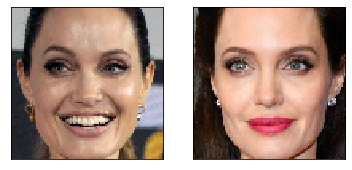

Verified!!!
They are same person.
Cosine Similarity:  0.90136427


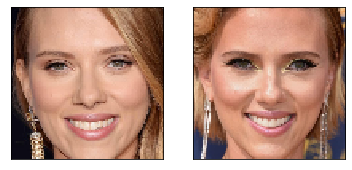

Verified!!!
They are same person.
Cosine Similarity:  0.9297766


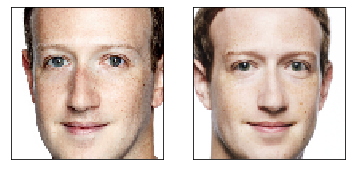

Verified!!!
They are same person.
Cosine Similarity:  0.91757095


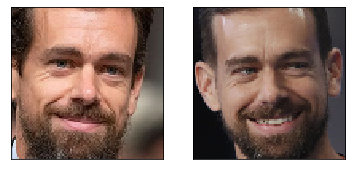

Verified!!!
They are same person.
Cosine Similarity:  0.85910165


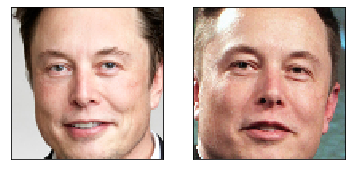

Verified!!!
They are same person.
Cosine Similarity:  0.71707654


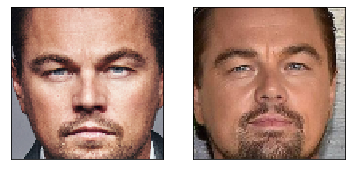

Verified!!!
They are same person.
Cosine Similarity:  0.7510954


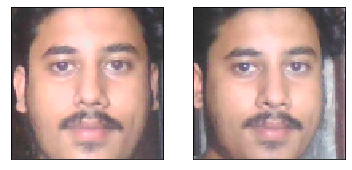

Verified!!!
They are same person.
Cosine Similarity:  0.9069602


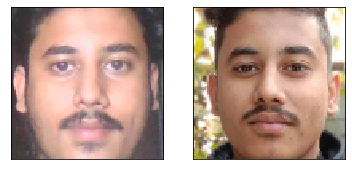

Verified!!!
They are same person.
Cosine Similarity:  0.8021586


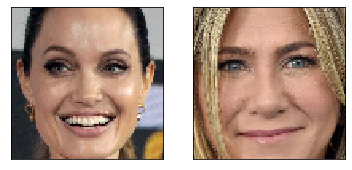

Unverified!!
They are different person
Cosine Similarity:  0.6934113


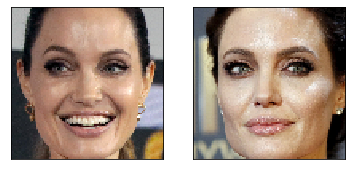

Verified!!!
They are same person.
Cosine Similarity:  0.8976313


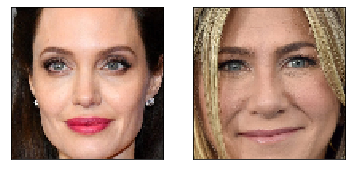

Unverified!!
They are different person
Cosine Similarity:  0.6452144


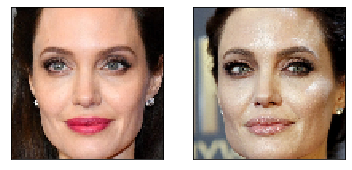

Verified!!!
They are same person.
Cosine Similarity:  0.84954363


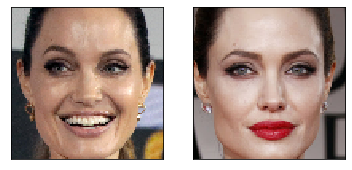

Verified!!!
They are same person.
Cosine Similarity:  0.8562615


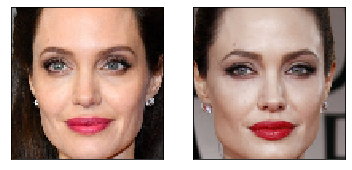

Verified!!!
They are same person.
Cosine Similarity:  0.8768536


In [48]:
for i in dataset:
    img1_path = i[0]
    img2_path = i[1]
    
    face1 = detect_face(img1_path)
    face2 = detect_face(img2_path)
    
    img1_representation = model.predict(face1)[0,:]
    img2_representation = model.predict(face2)[0,:]
    
    cosine_similarity = CosineSimilarity(img1_representation, img2_representation)
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(face1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(face2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    
    if(cosine_similarity > 0.717):
        print("Verified!!!")
        print("They are same person.")
        print("Cosine Similarity: ",  cosine_similarity)
        
    else:
        print("Unverified!!")
        print("They are different person")
        print("Cosine Similarity: ",  cosine_similarity)